
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## RBFs reconstruction and validation of historical and synthetic data

inputs required: 
  * Historical offshore waves (for plotting)
  * Synthetic offshore waves - emulator output climate change
  * Sea and swell SWAN simulated cases from ***Notebook 02_02***

in this notebook:
  * RBF reconstruction simulated storms
  * Return period comparison of historical and synthetic storms (with and without climate change)
  * Validation: AWAC measurement - Synthetic and historical histograms - Extremes  

### TODO

(NICO) Mi duda viene de los resultados de la propagación a nearshore que vemos aqui, no veo diferencias después de modificar los TCs, entiendo que las olas más grandes rompen igualmente en SWAN... a no ser que incorporemos la variable level...

¿Tendría sentido aplicar SLR antes de llegar aquí? Voy por partes:
    
    * En el siguiente notebook (02_04_Hycreww_RunUp) se suma el SLR.scenario=1.0 al nivel
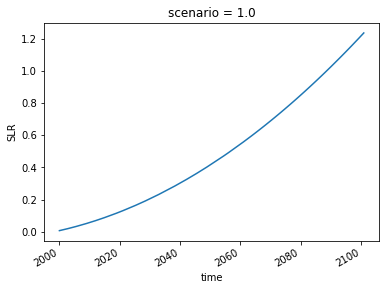

    * Las RBF que usamos aquí se han entrenado con un subset de casos SWAN que no consideran este aumento. 
    * Los casos swan son STATIONARY (no time), pero podríamos incorporar al MDA los valores SLR.scenario=1.0 
      como una dimension más y volver a clasificar->propagar->alimentar RBF.

Quiero indicar que sería laborioso, ya que habría que hacer varios cambios: 
    
    1. Añadir, Alterar y reejecutar 02_01_WAVES_MDA_Classification.ipynb, con la dimensión extra SLR
       y crear nuevo dataset / subset
    2. Alterar mw_deltares/swan.py para permitir lanzar un subset SWAN con casos 
       que tengan diferentes valores de level y añadir un 02_02_SWAN_Numerical_Propagation.ipynb
    3. Alimentar unas nuevas RBFs con este nuevo subset de casos resueltos (que tienen en cuenta diferente level)
    4. Utilizar esas RBFs en este notebook para llevar a nearshore nuestros casos con diferente level
    
Creo que puede ser mucho trabajo para poco resultado. Pero dejo aquí mis comentarios. 

Para ésto también habria que sumar SLR antes y no al final en hycreww.


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies, AWL
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation_v2
from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [ ]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S5
db_S5 = Database(p_data)
db_S5.SetSite('ROI_CC_S5')


## Prepare Sea and Swells data

In [ ]:
def split_sea_swells(WVS):
    '''
    splits WVS dataframe data into sea waves & swell waves dataframes
    
    requires WVS to contain variables with these names:
        'sea_Hs', 'sea_Tp', 'sea_Dir'
        'swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir'
        'swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir'
        ...
    
    '''
    
    # store n_sim if found in WVS dataset
    vns_extra = []
    if 'n_sim' in list(WVS.columns):
        vns_extra.append('n_sim') 

    
    # Prepare SEA waves
    vns_sea = ['sea_Hs', 'sea_Tp', 'sea_Dir'] + vns_extra
    
    wvs_sea = WVS[vns_sea]
    wvs_sea.dropna(inplace=True)  # clean nans
    wvs_sea.rename(columns={"sea_Hs":"hs", "sea_Tp":"tp", "sea_Dir": "dir"}, inplace=True)  # rename columns
    wvs_sea = wvs_sea[wvs_sea["dir"]<=360]  # filter data
    
    # Prepare SWELL_1 waves
    vns_swell_1 = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir'] + vns_extra

    wvs_swell_1 = WVS[vns_swell_1]
    wvs_swell_1.dropna(inplace=True)
    wvs_swell_1.rename(columns={"swell_1_Hs":"hs", "swell_1_Tp":"tp", "swell_1_Dir": "dir"}, inplace=True)
    wvs_swell_1 = wvs_swell_1[wvs_swell_1["dir"]<=360]  

    # Prepare SWELL_2 waves
    vns_swell_2 = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir'] + vns_extra

    wvs_swell_2 = WVS[vns_swell_2]
    wvs_swell_2.dropna(inplace=True)
    wvs_swell_2.rename(columns={"swell_2_Hs":"hs", "swell_2_Tp":"tp", "swell_2_Dir": "dir"}, inplace=True)
    wvs_swell_2 = wvs_swell_2[wvs_swell_2["dir"]<=360]  


    # join swell data
    wvs_swell = pd.concat([wvs_swell_1, wvs_swell_2], ignore_index=True)
    
    return wvs_sea, wvs_swell


# --------------------------------------
# Waves data

# Climate Emulator DWTs-WVS simulations climate change
WVS_sim_CC = db_S5.Load_CE_AllSims()


# --------------------------------------
# split waves data by family

# Prepare Simulated waves: split sea, swells
wvs_sea_sim_CC, wvs_swl_sim_CC = split_sea_swells(WVS_sim_CC)
db_S5.Save_NEARSHORE_SIM_sea(wvs_sea_sim_CC)
db_S5.Save_NEARSHORE_SIM_swell(wvs_swl_sim_CC)


In [ ]:
# input files: dataset, subset (MDA classification), and target (SWAN simulations output)

# sea 
wvs_sea_dataset_sim_CC = db_S5.Load_NEARSHORE_SIM_sea() # offshore climate change
wvs_sea_subset = db.Load_NEARSHORE_MDA_sea()
wvs_sea_target = db.Load_NEARSHORE_TARGET_sea() # SWAN simulation outputs

# swells 
wvs_swell_dataset_sim_CC = db_S5.Load_NEARSHORE_SIM_swell() # offshore climate change
wvs_swell_subset = db.Load_NEARSHORE_MDA_swell()
wvs_swell_target = db.Load_NEARSHORE_TARGET_swell() # SWAN simulation outputs

# keep datasets n_sim column
sea_n_sim_CC = wvs_sea_dataset_sim_CC['n_sim']
swl_n_sim_CC = wvs_swell_dataset_sim_CC['n_sim']


# remove nans (if any) from subset and target
def fix_target_nans(subset, target):
    'remove NaN data indexes from subset and target. RBF does not handle NaNs'
    
    r_nan = target.isnull().any(axis=1)  # find any row with nans

    if r_nan.any():
        # log
        print('remove nan data found at target:')
        print(target[r_nan])
        
        # clean data
        target = target[~r_nan]
        subset = subset[~r_nan]
        
    return subset, target

wvs_sea_subset, wvs_sea_target = fix_target_nans(wvs_sea_subset, wvs_sea_target)
wvs_swell_subset, wvs_swell_target = fix_target_nans(wvs_swell_subset, wvs_swell_target)


# ensure dataset and subset have same variables and column order
vns_ds = ['hs', 'tp', 'dir']

wvs_sea_dataset_sim_CC = wvs_sea_dataset_sim_CC[vns_ds].values
wvs_sea_subset = wvs_sea_subset[vns_ds].values

wvs_swell_dataset_sim_CC = wvs_swell_dataset_sim_CC[vns_ds].values
wvs_swell_subset = wvs_swell_subset[vns_ds].values


# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

wvs_sea_target = wvs_sea_target[vns_tgt].values
wvs_swell_target = wvs_swell_target[vns_tgt].values


In [ ]:
# RBF settings

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


# RBF wrappers 
def RBF_Reconstruction_sea(dataset_input):
    
    return RBF_Reconstruction(
    wvs_sea_subset, ix_scalar_subset, ix_directional_subset,
    wvs_sea_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_swell(dataset_input):
    
    return RBF_Reconstruction(
    wvs_swell_subset, ix_scalar_subset, ix_directional_subset,
    wvs_swell_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_families(data):
   
    # sea
    vs = ['sea_Hs', 'sea_Tp', 'sea_Dir']
    data_sea = data[vs].to_dataframe().dropna()
    data_sea.drop(data_sea[(data_sea['sea_Dir'] >= 360)].index, inplace=True)  # fix sea_Dir >> 360 bug    
    rec_sea = RBF_Reconstruction_sea(data_sea.values)
    rec_sea = pd.DataFrame(data=rec_sea, columns=vs, index=data_sea.index)

    # swell 1
    vs = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir']
    data_swl_1 = data[vs].to_dataframe().dropna()
    rec_swl_1 = RBF_Reconstruction_swell(data_swl_1.values)
    rec_swl_1 = pd.DataFrame(data=rec_swl_1, columns=vs, index=data_swl_1.index)

    # swell 2
    vs = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir']
    data_swl_2 = data[vs].to_dataframe().dropna()
    rec_swl_2 = RBF_Reconstruction_swell(data_swl_2.values)
    rec_swl_2 = pd.DataFrame(data=rec_swl_2, columns=vs, index=data_swl_2.index)
    
    # join nearshore reconstructed data and parse to xarray.Dataset
    rec_waves = pd.concat([rec_sea, rec_swl_1, rec_swl_2], axis=1)

    return xr.Dataset.from_dataframe(rec_waves)
     


## RBF Reconstruct SEA Waves

In [ ]:
# --------------------------------------
# RBF Interpolation

# Simulated SEA waves
sea_rec_sim_CC = RBF_Reconstruction_sea(wvs_sea_dataset_sim_CC)
df_sea_recon_sim_CC = pd.DataFrame(data=sea_rec_sim_CC, columns=vns_tgt)
df_sea_recon_sim_CC['n_sim'] = sea_n_sim_CC  # keep n_sim value


# store data
db_S5.Save_NEARSHORE_RECONSTRUCTION_SIM_sea(df_sea_recon_sim_CC)



## RBF Reconstruct SWELL Waves

In [ ]:
# --------------------------------------
# RBF Interpolation

# Simulated SWELL waves
swl_rec_sim_CC = RBF_Reconstruction_swell(wvs_swell_dataset_sim_CC)
df_swl_recon_sim_CC = pd.DataFrame(data=swl_rec_sim_CC, columns=vns_tgt)
df_swl_recon_sim_CC['n_sim'] = swl_n_sim_CC  # keep n_sim value


# store data
db_S5.Save_NEARSHORE_RECONSTRUCTION_SIM_swell(df_swl_recon_sim_CC)



## Load historical and simulated OFFSHORE waves

In [ ]:
# Load climate emulator historical waves (storms)
WVS_hist = db.Load_HIST_Complete_storms()
WVS_hist['AWL'] = AWL(WVS_hist.Hs, WVS_hist.Tp) # calculate AWL


# Load climate emulator simulation waves (storms)
n_sims_DWTs = 10
l_WVS_sim = db.Load_SIM_Complete_storms(n_sims_DWTs)
for WVS_sim in l_WVS_sim: WVS_sim['AWL'] = AWL(WVS_sim.Hs, WVS_sim.Tp) # calculate AWL

# Load climate emulator simulation waves (storms) climate change
l_WVS_sim_CC = db_S5.Load_SIM_Complete_storms(n_sims_DWTs)
for WVS_sim in l_WVS_sim_CC: WVS_sim['AWL'] = AWL(WVS_sim.Hs, WVS_sim.Tp) # calculate AWL


In [ ]:
# compare historical and simulations annual maxima (for storms)

vns = ['Hs', 'Tp', 'AWL']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
    sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim], 'n_sim')
    sim_B = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim_CC], 'n_sim')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation_v2(hist_A, sim_A, sim_B);



##  Reconstructed Historical storms

In [ ]:
    
# Load historical storms waves reconstruction
WVS_HIST_rec = db.Load_NEARSHORE_RECONSTRUCTION_HIST_storms()



## RBF Reconstruct Simulation storms

In [ ]:

l_sims_rec_CC = []
for data in l_WVS_sim_CC:
    
    # Reconstruct waves by families
    WVS_SIM_rec = RBF_Reconstruction_families(data)
    
    # aggregate nearshore variables
    WVS_a = Aggregate_WavesFamilies(WVS_SIM_rec)
    WVS_SIM_rec = xr.merge([WVS_SIM_rec, WVS_a])
    
    # calculate AWL
    WVS_SIM_rec['AWL'] = AWL(WVS_SIM_rec.Hs, WVS_SIM_rec.Tp)

    l_sims_rec_CC.append(WVS_SIM_rec)
    
    
# store simulations storms waves reconstruction
db_S5.Save_NEARSHORE_RECONSTRUCTION_SIM_storms(l_sims_rec_CC)




## Methodology Validation: NEARSHORE Historical - Simulation Annual Maxima

In [ ]:
# compare historical and simulations reconstruction vars. annual maxima
l_sims_rec = db.Load_NEARSHORE_RECONSTRUCTION_SIM_storms(n_sims=10)

vns = ['Hs', 'Tp', 'AWL']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = WVS_HIST_rec[vn].groupby('time.year').max(dim='time')
    sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_sims_rec], 'n_sim')
    sim_B = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_sims_rec_CC], 'n_sim')


    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation_v2(hist_A, sim_A, sim_B);
    